<a href="https://colab.research.google.com/github/CamiloRios11/SenalesySistemas2/blob/main/Parcial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parcial 2**:



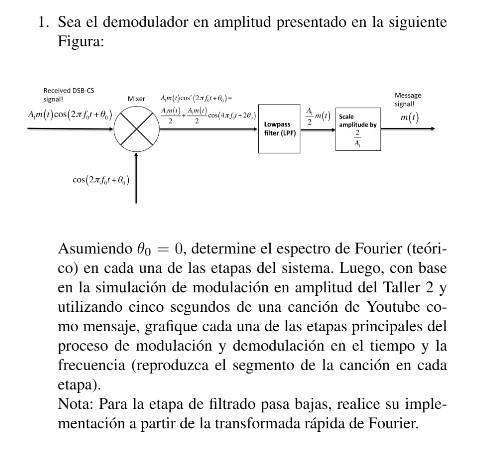

In [13]:
!pip install streamlit -q

In [14]:
!mkdir pages

mkdir: cannot create directory ‘pages’: File exists


In [18]:
%%writefile 0_👋_Hello.py
import streamlit as st
import numpy as np
import scipy.fft as fft
from scipy.io import wavfile
import scipy.signal
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import io
import os
import yt_dlp

# Configuración de página
st.set_page_config(page_title="Simulación Demodulación AM DSB-SC", layout="wide")

st.title("📡 Laboratorio Virtual: Demodulación de Amplitud (DSB-SC)")
st.markdown("""
Esta aplicación resuelve el punto del parcial simulando las etapas de modulación y demodulación síncrona.
Puedes usar un archivo local o **pegar un link de YouTube**.
""")

# --- BARRA LATERAL (CONTROLES) ---
st.sidebar.header("Parámetros del Sistema")

# Selector de fuente de audio
source_type = st.sidebar.radio("Selecciona Fuente de Audio:", ["Subir Archivo (.wav)", "YouTube URL"])

uploaded_file = None
youtube_url = None

if source_type == "Subir Archivo (.wav)":
    uploaded_file = st.sidebar.file_uploader("Cargar Audio", type=["wav"])
else:
    youtube_url = st.sidebar.text_input("Pega el link de YouTube aquí:")
    st.sidebar.caption("Nota: Requiere FFmpeg instalado en el sistema.")

f_c = st.sidebar.slider("Frecuencia Portadora (f0) [Hz]",
                        min_value=1000, max_value=20000, value=10000, step=1000)
cutoff_freq = st.sidebar.slider("Corte Filtro Pasa Bajas [Hz]",
                                min_value=100, max_value=5000, value=4000, step=100)

st.sidebar.markdown("---")
st.sidebar.markdown("**Datos del problema:**")
st.sidebar.latex(r"\theta_0 = 0")

# --- FUNCIONES DE AYUDA ---

def download_youtube_audio(url):
    """Descarga audio de YT, lo convierte a WAV y devuelve la ruta."""
    output_filename = "temp_audio"

    # Opciones para yt-dlp: descargar audio, convertir a wav
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
        'outtmpl': output_filename, # Nombre del archivo de salida (sin extensión)
        'quiet': True,
        'noplaylist': True,
        'overwrites': True
    }

    try:
        # Limpiar archivo previo si existe
        if os.path.exists(output_filename + ".wav"):
            os.remove(output_filename + ".wav")

        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])

        return output_filename + ".wav"
    except Exception as e:
        st.error(f"Error descargando de YouTube: {e}. Asegúrate de tener FFmpeg instalado.")
        return None

def load_audio_data(file_input, is_path=False):
    """Carga audio desde archivo subido o ruta local."""
    try:
        if is_path:
            rate, data = wavfile.read(file_input)
        else:
            rate, data = wavfile.read(io.BytesIO(file_input.getvalue()))

        # Convertir a mono
        if len(data.shape) > 1:
            data = data.mean(axis=1)

        # Normalizar entre -1 y 1
        data = data.astype(np.float32)
        data = data / np.max(np.abs(data))

        # Recortar a 5 segundos
        if len(data) > rate * 5:
            data = data[:rate * 5]

        return rate, data
    except Exception as e:
        st.error(f"Error al procesar audio: {e}")
        return None, None

def generate_tone():
    fs = 44100
    t = np.linspace(0, 5, 5 * fs)
    data = 0.5 * np.cos(2 * np.pi * 440 * t) + 0.3 * np.cos(2 * np.pi * 1000 * t)
    return fs, data

def fft_filter(signal, fs, cutoff):
    N = len(signal)
    Y = fft.fft(signal)
    freqs = fft.fftfreq(N, 1/fs)
    mask = np.abs(freqs) <= cutoff
    Y_filtered = Y * mask
    signal_filtered = fft.ifft(Y_filtered).real
    return signal_filtered

def plot_analysis(t, signal, fs, title, color_line):
    decim = max(1, len(t) // 1000)
    N = len(signal)
    Y = fft.fft(signal)
    freqs = fft.fftfreq(N, 1/fs)
    Y_shift = fft.fftshift(Y)
    freqs_shift = fft.fftshift(freqs)
    mag = np.abs(Y_shift) / N

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Tiempo (Zoom)", "Frecuencia"))
    fig.add_trace(go.Scatter(x=t[::decim], y=signal[::decim], name="Amp", line=dict(color=color_line, width=1)), row=1, col=1)

    max_f_view = f_c * 2.5 if f_c > 0 else 20000
    mask_view = np.abs(freqs_shift) < max_f_view
    fig.add_trace(go.Scatter(x=freqs_shift[mask_view], y=mag[mask_view], name="Espectro", line=dict(color='purple', width=1)), row=1, col=2)

    fig.update_layout(title_text=title, height=350, showlegend=False, margin=dict(l=20, r=20, t=40, b=20))
    return fig

# --- LÓGICA PRINCIPAL ---

m_t = None
fs_orig = 44100
source_name = ""

# Lógica de carga
if source_type == "Subir Archivo (.wav)" and uploaded_file is not None:
    fs_orig, m_t = load_audio_data(uploaded_file, is_path=False)
    source_name = "Archivo Subido"

elif source_type == "YouTube URL" and youtube_url:
    if st.sidebar.button("Descargar y Procesar"):
        with st.spinner("Descargando audio de YouTube... (esto puede tardar unos segundos)"):
            file_path = download_youtube_audio(youtube_url)
            if file_path:
                fs_orig, m_t = load_audio_data(file_path, is_path=True)
                source_name = "Audio de YouTube"
                # Opcional: limpiar archivo temporal después de cargar
                # os.remove(file_path)
    elif not m_t:
        st.info("Ingresa una URL y presiona 'Descargar y Procesar'")

# Si no hay nada cargado aún, usar tono por defecto
if m_t is None and not (source_type == "YouTube URL" and youtube_url):
    st.warning("No hay audio seleccionado. Usando tono de prueba.")
    fs_orig, m_t = generate_tone()
    source_name = "Tono Generado"

# --- PROCESAMIENTO (Solo si tenemos m_t) ---
if m_t is not None:

    # Upsampling para simulación
    target_fs = max(fs_orig, 4 * f_c)
    if target_fs != fs_orig:
        num_samples = int(len(m_t) * target_fs / fs_orig)
        m_t = scipy.signal.resample(m_t, num_samples)
        fs_sim = target_fs
    else:
        fs_sim = fs_orig

    t = np.linspace(0, len(m_t)/fs_sim, len(m_t), endpoint=False)

    # 1. Modulación
    A_1 = 1.0
    carrier = np.cos(2 * np.pi * f_c * t)
    dsb_signal = A_1 * m_t * carrier

    # 2. Demodulación (Mezcla)
    mixer_output = dsb_signal * carrier

    # 3. Filtrado (FFT)
    filtered_output = fft_filter(mixer_output, fs_sim, cutoff_freq)

    # 4. Escalado
    final_output = filtered_output * (2 / A_1)

    # --- VISUALIZACIÓN ---
    st.header(f"1. Mensaje Original: {source_name}")
    st.plotly_chart(plot_analysis(t, m_t, fs_sim, "Mensaje Original", "blue"), use_container_width=True)
    if source_type == "YouTube URL":
         # Reproducir audio original resampling al fs standard para que el navegador lo entienda
         st.audio(m_t, sample_rate=int(fs_sim))
    elif uploaded_file:
         st.audio(uploaded_file)
    else:
         st.audio(m_t, sample_rate=int(fs_sim))

    st.header("2. Modulación DSB-SC")
    st.plotly_chart(plot_analysis(t, dsb_signal, fs_sim, f"Señal Modulada (f0={f_c}Hz)", "orange"), use_container_width=True)
    # Audio modulado
    st.audio(dsb_signal/np.max(np.abs(dsb_signal)), sample_rate=int(fs_sim))

    st.header("3. Demodulación (Mezclador + Filtro)")
    col1, col2 = st.columns(2)
    with col1:
        st.subheader("Salida Mezclador (Antes del Filtro)")
        st.plotly_chart(plot_analysis(t, mixer_output, fs_sim, "Mezclador", "green"), use_container_width=True)
    with col2:
        st.subheader("Salida Final (Recuperada)")
        st.plotly_chart(plot_analysis(t, final_output, fs_sim, "Recuperada", "red"), use_container_width=True)

    st.success("✅ Audio Recuperado:")
    st.audio(final_output/np.max(np.abs(final_output)), sample_rate=int(fs_sim))

Overwriting 0_👋_Hello.py


In [19]:
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
!mv cloudflared-linux-amd64 /usr/local/bin/cloudflared

#Ejecutar Streamlit
!streamlit run 0_👋_Hello.py &>/content/logs.txt & #Cambiar 0_👋_Hello.py por el nombre de tu archivo principal

#Exponer el puerto 8501 con Cloudflare Tunnel
!cloudflared tunnel --url http://localhost:8501 > /content/cloudflared.log 2>&1 &

#Leer la URL pública generada por Cloudflare
import time
time.sleep(5)  # Esperar que se genere la URL

import re
found_context = False  # Indicador para saber si estamos en la sección correcta

with open('/content/cloudflared.log') as f:
    for line in f:
        #Detecta el inicio del contexto que nos interesa
        if "Your quick Tunnel has been created" in line:
            found_context = True

        #Busca una URL si ya se encontró el contexto relevante
        if found_context:
            match = re.search(r'https?://\S+', line)
            if match:
                url = match.group(0)  #Extrae la URL encontrada
                print(f'Tu aplicación está disponible en: {url}')
                break  #Termina el bucle después de encontrar la URL

--2025-12-02 21:05:17--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64 [following]
--2025-12-02 21:05:18--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/955e9d1b-ac5e-4188-8867-e5f53958a8fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-02T21%3A45%3A51Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-02

In [20]:
import os

res = input("Digite (1) para finalizar la ejecución del Dashboard: ")

if res.upper() == "1":
    os.system("pkill streamlit")  # Termina el proceso de Streamlit
    print("El proceso de Streamlit ha sido finalizado.")


Digite (1) para finalizar la ejecución del Dashboard: 1
El proceso de Streamlit ha sido finalizado.


**Pregunta 2:**Encuentre la funcion de transferencia en lazo abierto que caracteriza el sistema masa, resorte, amortiguador, presentado en la siguiente Figura (asuma condiciones iniciales cero):

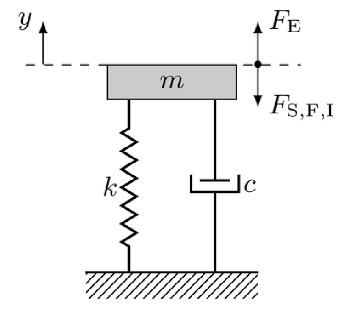

Posteriormente, encuentre el sistema equivalente del modelo
masa, resorte, amortiguador, a partir del siguiente circuito
electrico:

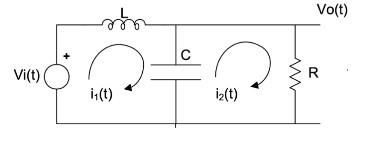

Utilizando la herramienta Streamlit, desarrolle un panel interactivo
(dashboard) para la simulacion de los sistemas estudiados.
El usuario podra seleccionar el tipo de respuesta
del sistema (subamortiguada, sobreamortiguada, con amortiguamiento
crıtico o inestable), ası como ajustar el valor del
factor de amortiguamiento (restringido segun el tipo de respuesta)
y la frecuencia natural.
El dashboard debera visualizar (en configuracion lazo abierto
y lazo cerrado): el diagrama de Bode, el diagrama de polos
y ceros, las respuestas al impulso, al escalon y a la rampa, ası
como los siguientes parametros temporales: tiempo de levantamiento,
sobre-impulso maximo, tiempo en el que ocurre el
sobre-impulso, y tiempo de establecimiento. Tambien, deber
a mostrar los valores estimados de los componentes de
los sistemas (masa, resorte, amortiguador y R, L, C).

El dashboard se encuentra en el siguiente colab:
https://colab.research.google.com/drive/1n_4aFJSWgmPefTtOdWXRqryHscQp2tCK#scrollTo=BcNujjaS5RA5